In [1]:
import os
import ast
import csv
import cv2
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [8]:
video_dir = '/Users/wbarbour1/Downloads/I24_video/timestamp_test/ingest_session_00011/recording'

In [9]:
video_files = [os.path.join(video_dir, vf) for vf in os.listdir(video_dir)]
print(video_files)

['/Users/wbarbour1/Downloads/I24_video/timestamp_test/ingest_session_00011/recording/record_p1c5_00000.mp4', '/Users/wbarbour1/Downloads/I24_video/timestamp_test/ingest_session_00011/recording/record_p2c2_00000.mp4', '/Users/wbarbour1/Downloads/I24_video/timestamp_test/ingest_session_00011/recording/record_p3c0_00000.mp4', '/Users/wbarbour1/Downloads/I24_video/timestamp_test/ingest_session_00011/recording/record_p1c3_00000.mp4', '/Users/wbarbour1/Downloads/I24_video/timestamp_test/ingest_session_00011/recording/record_p2c4_00000.mp4', '/Users/wbarbour1/Downloads/I24_video/timestamp_test/ingest_session_00011/recording/record_p1c4_00000.mp4', '/Users/wbarbour1/Downloads/I24_video/timestamp_test/ingest_session_00011/recording/record_p2c3_00000.mp4', '/Users/wbarbour1/Downloads/I24_video/timestamp_test/ingest_session_00011/recording/record_p3c1_00000.mp4', '/Users/wbarbour1/Downloads/I24_video/timestamp_test/ingest_session_00011/recording/record_p1c2_00000.mp4', '/Users/wbarbour1/Downloads

In [65]:
w = 8
h = 12
x0 = 10
y0 = 2
n = 13
h13 = int(h/3)
h23 = int(2*h/3)
h12 = int(h/2)
w12 = int(w/2)

In [119]:
with open('./resources/timestamp_geometry_4K.pkl', 'wb') as f:
    pickle.dump({'w': w, 'h': h, 'x0': x0, 'y0': y0, 'n': n, 
                 'h13': h13, 'h23': h23, 'h12': h12, 'w12': w12}, f)

In [40]:
digits = {}
video_file = video_files[0]
# (digit, frame_i, character_i)
get_dig = [(0, 11, 11), (1, 14, 11), (2, 17, 11), (3, 20, 11), (4, 23, 11), 
           (5, 26 ,11), (6, 29, 11), (7, 32, 11), (8, 35, 11), (9, 38, 11)]
try:
    cap = cv2.VideoCapture(video_file)
    assert cap.isOpened(), "Cannot open file \"{}\"".format(video_file)
    
    i = 0
    dig, fri, chi = zip(*get_dig)
    
    while i <= max(fri):
        ret, frame = cap.read()
        # check if we need to extract from this frame
        if i in fri:
            # convert timestamp to black/white
            tsimg = frame[0:y0+h, 0:x0+(n*w), :]
            tsgray = cv2.cvtColor(tsimg, cv2.COLOR_BGR2GRAY)
            ret, tsmask = cv2.threshold(tsgray, 127, 255, cv2.THRESH_BINARY)
            # extract digits for any references of this frame
            for j in range(len(fri)):
                if fri[j] == i:
                    pixels = tsmask[y0:y0+h, x0+chi[j]*w:x0+(chi[j]+1)*w]
                    digits[dig[j]] = pixels
        i += 1
        continue
except BaseException as e:
    print(e)
finally:
    cap.release()

In [117]:
with open('./timestamp_digits.pkl', 'wb') as f:
    pickle.dump(digits, f)

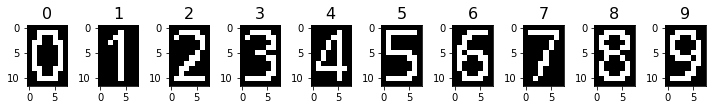

In [41]:
fig, axs = plt.subplots(1, len(digits), figsize=(len(digits), 2))
for i, (dig, pixels) in enumerate(sorted(digits.items())):
    axs[i].imshow(pixels, 'gray')
    axs[i].set_title(str(dig), fontsize=16)
plt.tight_layout()
plt.show()

In [69]:
dig_checksum4 = {}
dig_checksum6 = {}
for dig, pixels in sorted(digits.items()):
#     print('\n', dig)
    cs = [[int(pixels[:h12, :w12].sum()/255), int(pixels[:h12, w12:].sum()/255)],
          [int(pixels[h12:, :w12].sum()/255), int(pixels[h12:, w12:].sum()/255)]
         ]
    cs = np.array(cs)
#     print(cs)
    dig_checksum4[dig] = cs
    cs = [[int(pixels[:h13, :w12].sum()/255), int(pixels[:h13, w12:].sum()/255)], 
          [int(pixels[h13:h23, :w12].sum()/255), int(pixels[h13:h23, w12:].sum()/255)],
          [int(pixels[h23:, :w12].sum()/255), int(pixels[h23:, w12:].sum()/255)]
         ]
    cs = np.array(cs)
#     print(cs)
    dig_checksum6[dig] = cs

In [118]:
with open('./timestamp_pixel_checksum_6.pkl', 'wb') as f:
    pickle.dump(dig_checksum6, f)
with open('./timestamp_pixel_checksum_4.pkl', 'wb') as f:
    pickle.dump(dig_checksum4, f)

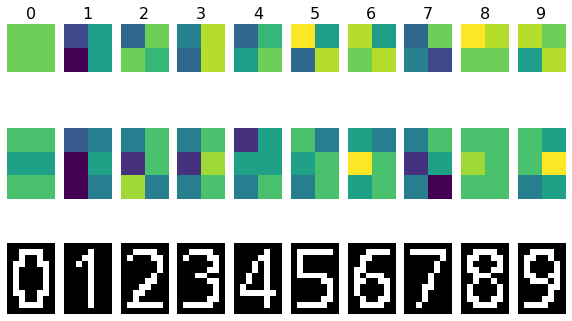

In [120]:
fig, axs = plt.subplots(3, len(dig_checksum6), figsize=(len(dig_checksum6), 6))
vmin4 = min([np.array(cs).min() for cs in dig_checksum4.values()])
vmax4 = max([np.array(cs).max() for cs in dig_checksum4.values()])
vmin6 = min([np.array(cs).min() for cs in dig_checksum6.values()])
vmax6 = max([np.array(cs).max() for cs in dig_checksum6.values()])
for i, (dig, cs) in enumerate(sorted(dig_checksum6.items())):
    im6 = axs[1][i].imshow(cs, vmin=vmin6, vmax=vmax6)
    axs[1][i].set_axis_off()
#     axs[1][i].set_title(str(dig), fontsize=16)
    im4 = axs[0][i].imshow(dig_checksum4[dig], vmin=vmin4, vmax=vmax4)
    axs[0][i].set_axis_off()
    axs[0][i].set_title(str(dig), fontsize=16)
    axs[2][i].imshow(digits[dig], 'gray')
    axs[2][i].set_axis_off()
# cbar4 = fig.colorbar(im4, ax=axs[0].ravel().tolist(), shrink=0.95)
# cbar6 = fig.colorbar(im6, ax=axs[1].ravel().tolist(), shrink=0.95)
# plt.tight_layout()
plt.savefig('./resources/timestamp_digits_4K.pdf')
plt.show()

In [76]:
list(map(str, [1, 2, 3]))

['1', '2', '3']

In [114]:
video_file = video_files[0]
timestamps = {}
try:
    for video_file in video_files:
        t0 = time.time()
        cap = cv2.VideoCapture(video_file)
        assert cap.isOpened(), "Cannot open file \"{}\"".format(video_file)
        
        cam = video_file.split('record_')[1].split('_')[0]
        print("CAMERA {}".format(cam))
        cam_ts = []
        i = 0
        while True:
            ret, frame = cap.read()
            if frame is None:
                print("END OF VIDEO. BREAKING LOOP.")
                break
            tsimg = frame[0:y0+h, 0:x0+(n*w), :]
            tsgray = cv2.cvtColor(tsimg, cv2.COLOR_BGR2GRAY)
            ret, tsmask = cv2.threshold(tsgray, 127, 255, cv2.THRESH_BINARY)

            ts_dig = []
            for j in range(n):
                if j == 10:
                    ts_dig.append('.')
                    continue
                pixels = tsmask[y0:y0+h, x0+j*w:x0+(j+1)*w]
                cs = [[int(pixels[:h13, :w12].sum()/255), int(pixels[:h13, w12:].sum()/255)], 
                      [int(pixels[h13:h23, :w12].sum()/255), int(pixels[h13:h23, w12:].sum()/255)],
                      [int(pixels[h23:, :w12].sum()/255), int(pixels[h23:, w12:].sum()/255)]
                     ]
                cs = np.array(cs)
                cs_diff = [(dig, abs(cs - cs_ref).sum()) for dig, cs_ref in dig_checksum6.items()]
                pred_dig, pred_err = min(cs_diff, key=lambda x: x[1])
                if pred_err > 0:
                    print(cs)
                else:
                    ts_dig.append(pred_dig)
            cam_ts.append(ast.literal_eval(''.join(map(str, ts_dig))))
            i += 1
            continue
        timestamps[cam] = cam_ts
        cap.release()
        print(i / (time.time() - t0), "fps")
        
except BaseException as e:
    print(frame)
    raise e
finally:
    cap.release()

CAMERA p1c5
END OF VIDEO. BREAKING LOOP.
33.661428081545985 fps
CAMERA p2c2
[[[  2   2   2]
  [  2   2   2]
  [  2   2   2]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  2   2   2]
  [  2   2   2]
  [  2   2   2]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  2   2   2]
  [  2   2   2]
  [  2   2   2]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[140 157 155]
  [147 164 162]
  [144 161 159]
  ...
  [ 89 127 125]
  [ 84 122 120]
  [ 82 120 118]]

 [[146 156 155]
  [135 145 144]
  [143 156 154]
  ...
  [ 91 129 127]
  [ 88 126 124]
  [ 84 122 120]]

 [[135 145 144]
  [145 155 154]
  [171 184 182]
  ...
  [ 91 129 127]
  [ 88 126 124]
  [ 84 122 120]]]


KeyboardInterrupt: 

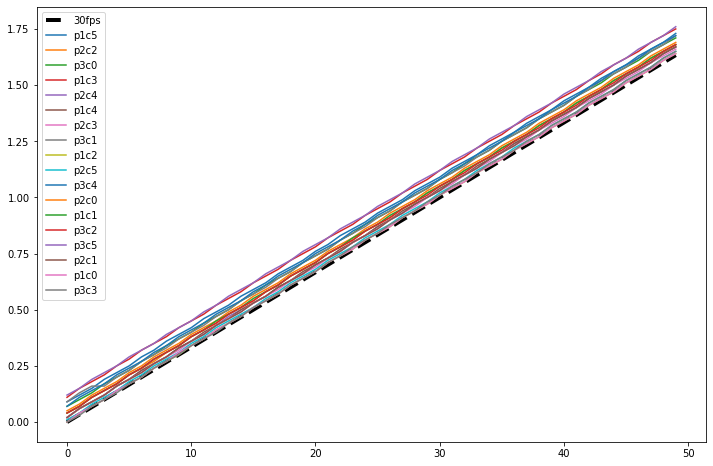

In [121]:
all_min = min([min(ts) for ts in timestamps.values()])
t_ref = [1/30 * ti for ti in range(max([len(ts) for ts in timestamps.values()]))]
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(t_ref[:50], 'k--', linewidth=4, label='30fps')
for cam, ts in timestamps.items():
    ts = [t - all_min for t in ts]
    ax.plot(ts[:50], label=cam)
plt.legend()
plt.show()

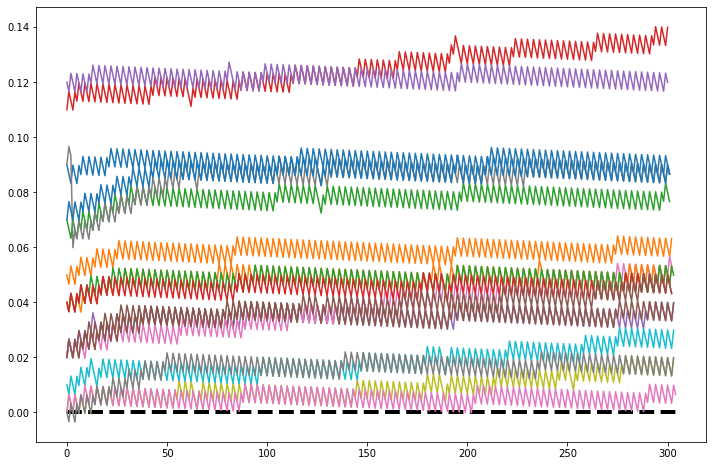

In [137]:
all_min = min([min(ts) for ts in timestamps.values()])
t_ref = [1/29.97 * ti for ti in range(max([len(ts) for ts in timestamps.values()]))]
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot([0 for _ in t_ref][:1000], 'k--', linewidth=4, label='30fps')
for cam, ts in timestamps.items():
    ts = [t - all_min - tr for t, tr in zip(ts, t_ref)]
    ax.plot(ts[:1000], label=cam)
# plt.legend()
plt.show()

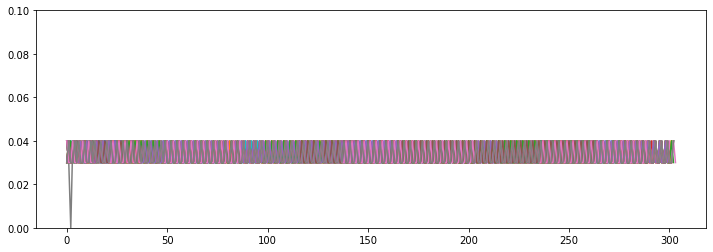

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
for cam, ts in timestamps.items():
    delta_t = [t2 - t1 for t1, t2 in zip(ts[:-1], ts[1:])]
    ax.plot(delta_t, label=cam)
ax.set_ylim((0, 0.1))
plt.show()

In [2]:
with open('/Users/wbarbour1/Downloads/frame_timestamp_recording.csv', 'r') as f:
    reader = csv.reader(f, delimiter=';', quoting=csv.QUOTE_NONNUMERIC)
    header = next(reader)
    lines = list(reader)

In [3]:
tsres = {l[0]: l[1:] for l in lines}

In [4]:
print(tsres.keys())

dict_keys(['/data/video/ingest_session_00012/recording/record_p3c5_00155.mp4', '/data/video/ingest_session_00012/recording/record_p3c5_00156.mp4'])


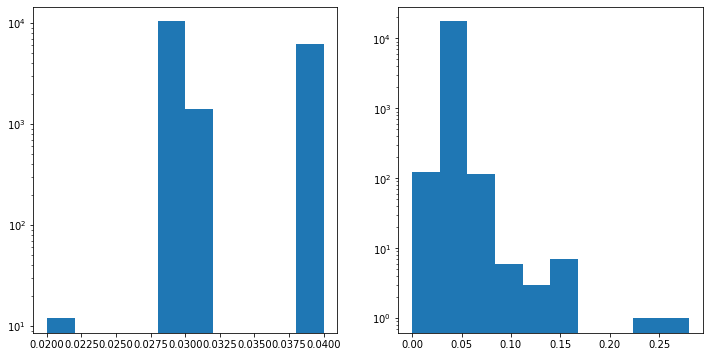

In [30]:
k1 = '/data/video/ingest_session_00012/recording/record_p3c5_00155.mp4'
k2 = '/data/video/ingest_session_00012/recording/record_p3c5_00156.mp4'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.hist([(t2 - t1) for t1, t2 in zip(tsres[k1][:-1], tsres[k1][1:])])
ax2.hist([(t2 - t1) for t1, t2 in zip(tsres[k2][:-1], tsres[k2][1:])])
ax1.set_yscale('log')
ax2.set_yscale('log')
plt.show()

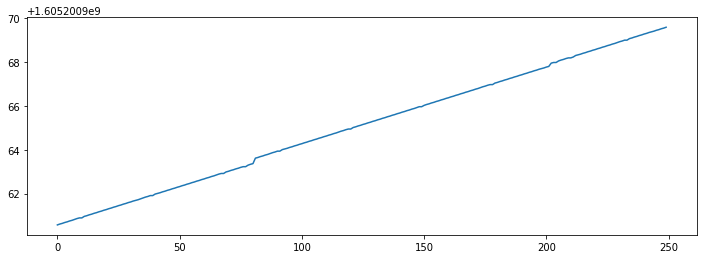

In [25]:
k = '/data/video/ingest_session_00012/recording/record_p3c5_00156.mp4'
vdif = [(t2 - t1) for t1, t2 in zip(tsres[k][:-1], tsres[k][1:])]
fig, ax = plt.subplots(1, 1, figsize=(12,4))
# ax.plot(tsres[k][12590:12800])
# ax.plot(vdif[12590:12800])
# ax.plot(vdif[13300:13550])
ax.plot(tsres[k][13300:13550])
# ax.hist(vdif)
plt.show()

In [17]:
print(tsres[k][12590:12800])

[1605200935.59, 1605200935.63, 1605200935.66, 1605200935.7, 1605200935.73, 1605200935.76, 1605200935.8, 1605200935.83, 1605200935.86, 1605200935.9, 1605200935.97, 1605200935.97, 1605200936.04, 1605200936.07, 1605200936.11, 1605200936.15, 1605200936.19, 1605200936.23, 1605200936.28, 1605200936.32, 1605200936.32, 1605200936.4, 1605200936.43, 1605200936.47, 1605200936.51, 1605200936.55, 1605200936.59, 1605200936.64, 1605200936.68, 1605200936.68, 1605200936.76, 1605200936.79, 1605200936.83, 1605200936.87, 1605200936.91, 1605200936.94, 1605200937.0, 1605200937.04, 1605200937.07, 1605200937.11, 1605200937.15, 1605200937.18, 1605200937.22, 1605200937.26, 1605200937.3, 1605200937.36, 1605200937.39, 1605200937.39, 1605200937.47, 1605200937.51, 1605200937.54, 1605200937.58, 1605200937.66, 1605200937.66, 1605200937.71, 1605200937.75, 1605200937.79, 1605200937.83, 1605200937.86, 1605200937.9, 1605200937.94, 1605200938.02, 1605200938.02, 1605200938.07, 1605200938.11, 1605200938.15, 1605200938.18, 1

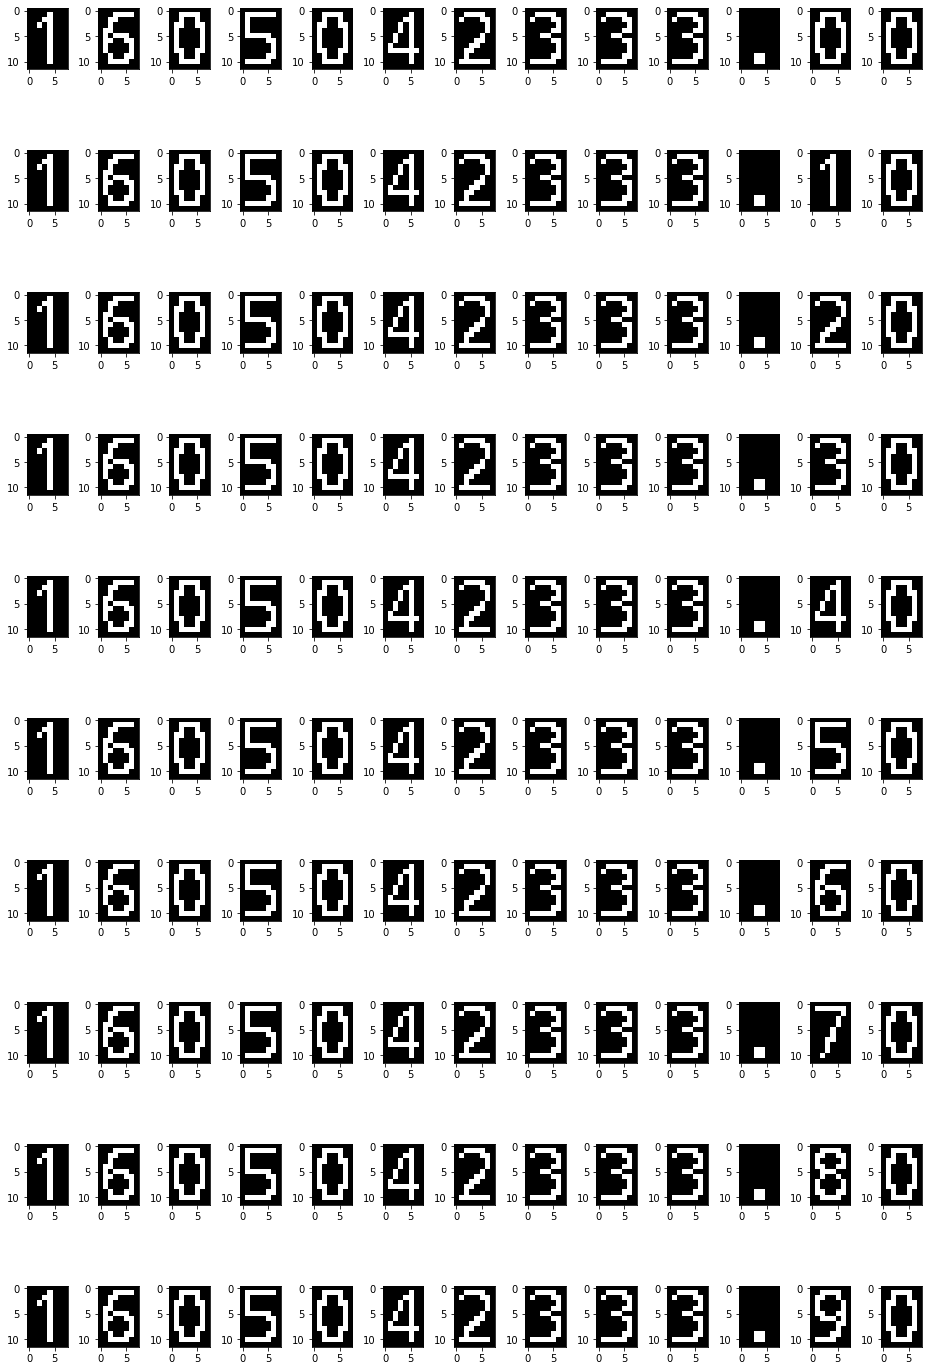

In [64]:
video_file = video_files[0]
fi = [11, 14, 17, 20, 23, 26, 29, 32, 35, 38]
frames = []
try:
    cap = cv2.VideoCapture(video_file)
    assert cap.isOpened(), "Cannot open file \"{}\"".format(video_file)
    
    i = 0
    fi.sort()
    while i <= max(fi):
        ret, frame = cap.read()
        if i in fi:
            frames.append(frame)
        i += 1
        continue
    
    fig, axs = plt.subplots(len(fi), n, figsize=(n, 2*len(fi)))
    for i in range(len(fi)):
        frame = frames[i]
        tsimg = frame[0:y0+h, 0:x0+(n*w), :]
        tsgray = cv2.cvtColor(tsimg, cv2.COLOR_BGR2GRAY)
        ret, tsmask = cv2.threshold(tsgray, 127, 255, cv2.THRESH_BINARY)
        
        for j in range(n):
            if len(fi) == 1:
                ax = axs[j]
            else:
                ax = axs[i][j]
            
            dig = tsmask[y0:y0+h, x0+j*w:x0+(j+1)*w]
            ax.imshow(dig, 'gray')
    plt.tight_layout()
    plt.show()
except BaseException as e:
    print(e)
finally:
    cap.release()

In [4]:
video_file = video_files[0]
try:
    cap = cv2.VideoCapture(video_file)
    assert cap.isOpened(), "Cannot open file \"{}\"".format(video_file)

    # opens VideoWriter object for saving video file if necessary
    out = None
    if False:
        # open video_writer object
        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))
        out = cv2.VideoWriter(save_file,cv2.CAP_FFMPEG,cv2.VideoWriter_fourcc('H','2','6','4'), 30, (frame_width,frame_height))

    #main loop   
    start = time.time()
    frames = 0
    ret = None
    all_detections = []

    # get first frame
    ret, frame = cap.read()

    while cap.isOpened():
        if ret is True:
            #summary statistics
            frames += 1
            print("Frame {}: {:5.2f} fps".format(frames, frames / (time.time() - start)))

            if out is not None:
                out.write(im)

            # output frame if necessary
            if True:
                im = cv2.resize(frame, (1920, 1080))               
                cv2.imshow("frame", im)
                key = cv2.waitKey(1)
                if key & 0xFF == ord('q'):
                    break
            
            # get next frame or None
            ret, frame = cap.read()
            
        else:
            break
except BaseException as e:
    raise e
finally:
    try:
        cap.release()
    except:
        pass
    cv2.destroyAllWindows()

Frame 1:  5.01 fps
Frame 2:  1.29 fps
Frame 3:  1.58 fps
Frame 4:  2.04 fps
Frame 5:  2.45 fps
Frame 6:  2.85 fps
Frame 7:  3.23 fps
Frame 8:  3.59 fps
Frame 9:  3.94 fps
Frame 10:  4.29 fps
Frame 11:  4.60 fps
Frame 12:  4.93 fps
Frame 13:  5.22 fps
Frame 14:  5.51 fps
Frame 15:  5.77 fps
Frame 16:  6.04 fps
Frame 17:  6.30 fps
Frame 18:  6.22 fps
Frame 19:  6.45 fps
Frame 20:  6.68 fps
Frame 21:  6.90 fps
Frame 22:  7.10 fps
Frame 23:  7.28 fps
Frame 24:  7.49 fps
Frame 25:  7.69 fps
Frame 26:  7.89 fps
Frame 27:  8.08 fps
Frame 28:  8.26 fps
Frame 29:  8.44 fps
Frame 30:  8.62 fps
Frame 31:  8.73 fps
Frame 32:  8.91 fps
Frame 33:  9.06 fps
Frame 34:  9.22 fps
Frame 35:  9.37 fps
Frame 36:  9.52 fps
Frame 37:  9.67 fps
Frame 38:  9.82 fps
Frame 39:  9.96 fps
Frame 40: 10.08 fps
Frame 41: 10.19 fps
Frame 42: 10.30 fps
Frame 43: 10.38 fps
Frame 44: 10.51 fps
Frame 45: 10.64 fps
Frame 46: 10.77 fps
Frame 47: 10.84 fps
Frame 48: 10.95 fps
Frame 49: 11.07 fps
Frame 50: 11.18 fps
Frame 51: